In [1]:
import threading
import time
import gymnasium as gym
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits
    
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        value = self.fc2(x)
        return value


In [3]:
class Agent:
    def __init__(self, global_actor, global_critic, global_actor_optimizer, global_critic_optimizer, state_dim, action_dim, gamma=0.99, n_steps=5,entropy_coef=0.01, optimizer_lock=None):
        """Worker agent that keeps local copies of actor/critic, collects n-step transitions,
        computes local gradients, and applies them to the global networks.

        Args:
            global_actor: global Actor network (shared)
            global_critic: global Critic network (shared)
            global_actor_optimizer: optimizer for global actor
            global_critic_optimizer: optimizer for global critic
            state_dim: dimension of the state vector
            action_dim: number of discrete actions
            gamma: discount factor
            n_steps: number of steps to accumulate before updating
        """
        self.global_actor = global_actor
        self.global_critic = global_critic
        self.global_actor_optimizer = global_actor_optimizer
        self.global_critic_optimizer = global_critic_optimizer
        self.gamma = gamma
        self.n_steps = n_steps
        self.entropy_coef = entropy_coef

        # Local networks (worker's copy)
        self.local_actor = Actor(state_dim, action_dim)
        self.local_critic = Critic(state_dim)
        self.optimizer_lock = optimizer_lock


        # Buffers for n-step returns
        self.states, self.actions, self.rewards = [], [], []

    def sync_with_global(self):
        """Copy parameters from global networks into the local networks."""
        self.local_actor.load_state_dict(self.global_actor.state_dict())
        self.local_critic.load_state_dict(self.global_critic.state_dict())

    def act(self, state):
        """Return an action sampled from the local actor and the log-probability tensor."""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        logits = self.local_actor(state)
        dist = torch.distributions.Categorical(logits=logits)
        action_tensor = dist.sample()
        return action_tensor.item(), dist.log_prob(action_tensor)

    def train(self, state, action, reward, next_state):
        """Store transition and, when enough steps or on episode end, perform an update.

        This follows the common n-step A3C style: compute n-step returns, compute
        advantages, compute local losses, backprop on local networks, copy local grads
        into global networks and step global optimizers.
        """
        # Store experience (DETACH to avoid large computation graphs and thread-safety issues)
        self.states.append(torch.tensor(state, dtype=torch.float32).unsqueeze(0).detach())
        # Ensure action is stored as a long tensor with shape (1,)
        self.actions.append(torch.tensor(action, dtype=torch.int64).unsqueeze(0).detach())
        # self.rewards.append(torch.tensor(reward, dtype=torch.float32).detach())
        self.rewards.append(float(reward))
        
    
        if len(self.rewards) >= self.n_steps or next_state is None:
            # Bootstrap from last state's value (0 if terminal)
            R = 0.0 if next_state is None else self.local_critic(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)).item()
            returns = []
            for r in reversed(self.rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            
            # returns = torch.as_tensor(returns, dtype=torch.float32)

            # Convert to tensors
            returns = torch.tensor(returns, dtype=torch.float32)
            state_tensor = torch.cat(self.states, dim=0)
            # Build action tensor robustly (handles scalar and 1-d tensors)
            action_tensor = torch.tensor([int(a.item()) if torch.is_tensor(a) else int(a) for a in self.actions], dtype=torch.int64)
            values = self.local_critic(state_tensor).squeeze()

            advantages = returns - values
            # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8) #check this out


            # Compute losses using local networks
            logits = self.local_actor(state_tensor)
            dist = torch.distributions.Categorical(logits=logits)
            log_probs = dist.log_prob(action_tensor)
            entropy = dist.entropy().mean()
            actor_loss = -(log_probs * advantages.detach()).mean() - self.entropy_coef * entropy
    
            # actor_loss = -(log_probs * advantages.detach()).mean()
            critic_loss = advantages.pow(2).mean()

            # Zero gradients on both local and global networks
            self.local_actor.zero_grad()
            self.local_critic.zero_grad()
            # self.global_actor_optimizer.zero_grad()
            # self.global_critic_optimizer.zero_grad()

            # # Backprop on local networks (populate local gradients)
            # actor_loss.backward()
            # critic_loss.backward()

            # # Copy local gradients into the global networks
            # for local_param, global_param in zip(self.local_actor.parameters(), self.global_actor.parameters()):
            #     if local_param.grad is not None:
            #         global_param.grad = local_param.grad.clone()

            # for local_param, global_param in zip(self.local_critic.parameters(), self.global_critic.parameters()):
            #     if local_param.grad is not None:
            #         global_param.grad = local_param.grad.clone()

            # # Step global optimizers
            # self.global_actor_optimizer.step()
            # self.global_critic_optimizer.step()

            # # Sync local networks with the updated globals and clear buffers
            # self.sync_with_global()
            # self.states, self.actions, self.rewards = [], [], []

            total_loss = actor_loss + critic_loss
            
            with self.optimizer_lock:
                self.global_actor_optimizer.zero_grad()
                self.global_critic_optimizer.zero_grad()

                total_loss.backward()

                for lp, gp in zip(self.local_actor.parameters(), self.global_actor.parameters()):
                    if lp.grad is not None:
                        if gp.grad is None:
                            gp.grad = lp.grad.detach().clone()
                        else:
                            gp.grad.copy_(lp.grad)

                for lp, gp in zip(self.local_critic.parameters(), self.global_critic.parameters()):
                    if lp.grad is not None:
                        if gp.grad is None:
                            gp.grad = lp.grad.detach().clone()
                        else:
                            gp.grad.copy_(lp.grad)

                torch.nn.utils.clip_grad_norm_(self.global_actor.parameters(), 40)
                torch.nn.utils.clip_grad_norm_(self.global_critic.parameters(), 40)

                self.global_actor_optimizer.step()
                self.global_critic_optimizer.step()

            # Sync locals
            self.sync_with_global()
            self.states, self.actions, self.rewards = [], [], []

            if next_state is None:
                self.entropy_coef = max(self.entropy_coef * 0.995, 0.0005)

In [4]:
import matplotlib.pyplot as plt
import threading

class Environment(threading.Thread):
    def __init__(self, env_name, agent, global_episode, global_step, global_lock, max_episodes, worker_id, log_dict):
        super().__init__()
        self.env = gym.make(env_name)
        self.agent = agent
        self.global_episode = global_episode
        self.global_step = global_step
        self.global_lock = global_lock
        self.max_episodes = max_episodes
        self.worker_id = worker_id
        self.log_dict = log_dict  # shared dictionary to store episode rewards
        print(f"Thread with id: {self.worker_id} created")

    def runEpisode(self):
        self.agent.sync_with_global()
        state, _ = self.env.reset()
        done = False
        episode_reward = 0.0

        while not done:
            action, _ = self.agent.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            if done:
                next_state = None

            self.agent.train(state, action, reward, next_state)

            state = next_state
            episode_reward += reward

            with self.global_lock:
                self.global_step[0] += 1

        # Log episode reward
        with self.global_lock:
            self.global_episode[0] += 1
            ep = self.global_episode[0]

            if self.worker_id not in self.log_dict:
                self.log_dict[self.worker_id] = []
            self.log_dict[self.worker_id].append(episode_reward)

            if ep % 10 == 0:
                print(
                    f"[Episode {ep}] "
                    f"Reward: {episode_reward:.1f} | "
                    f"Global steps: {self.global_step[0]}"
                )

    def run(self):
        while True:
            with self.global_lock:
                if self.global_episode[0] >= self.max_episodes:
                    break
            self.runEpisode()

        self.env.close()

    @staticmethod
    def plot_rewards(log_dict, smoothing_window=10):
        """Plot rewards per worker and overall moving average."""
        plt.figure(figsize=(12,6))
        for worker_id, rewards in log_dict.items():
            rewards = rewards
            moving_avg = [sum(rewards[max(0,i-smoothing_window+1):i+1])/min(i+1,smoothing_window)
                          for i in range(len(rewards))]
            plt.plot(rewards, alpha=0.3, label=f'Worker {worker_id} rewards')
            plt.plot(moving_avg, label=f'Worker {worker_id} MA({smoothing_window})')
        
        # Overall average across workers
        min_len = min(len(r) for r in log_dict.values())
        overall_avg = [sum(log_dict[w][i] for w in log_dict)/len(log_dict) for i in range(min_len)]
        plt.plot(overall_avg, color='black', linewidth=2, label='Overall Average')
        
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Episode Rewards per Worker')
        plt.legend()
        plt.show()


In [5]:
ENV_NAME = "CartPole-v1"
LR_actor = 1e-3
LR_critic = 3e-3

env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

global_actor = Actor(state_dim, action_dim)
global_critic = Critic(state_dim)

global_actor_optimizer = torch.optim.Adam(global_actor.parameters(), lr=LR_actor)
global_critic_optimizer = torch.optim.Adam(global_critic.parameters(), lr=LR_critic)


Thread with id: 0 created
Thread with id: 1 created
Thread with id: 2 created
Thread with id: 3 created
[Episode 10] Reward: 15.0 | Global steps: 325
[Episode 20] Reward: 33.0 | Global steps: 631
[Episode 30] Reward: 35.0 | Global steps: 856
[Episode 40] Reward: 19.0 | Global steps: 1191
[Episode 50] Reward: 11.0 | Global steps: 1356
[Episode 60] Reward: 36.0 | Global steps: 1563
[Episode 70] Reward: 22.0 | Global steps: 1786
[Episode 80] Reward: 22.0 | Global steps: 1941
[Episode 90] Reward: 29.0 | Global steps: 2302
[Episode 100] Reward: 21.0 | Global steps: 2505
[Episode 110] Reward: 30.0 | Global steps: 2670
[Episode 120] Reward: 12.0 | Global steps: 2817
[Episode 130] Reward: 13.0 | Global steps: 2938
[Episode 140] Reward: 72.0 | Global steps: 3350
[Episode 150] Reward: 35.0 | Global steps: 3628
[Episode 160] Reward: 106.0 | Global steps: 4148
[Episode 170] Reward: 42.0 | Global steps: 4506
[Episode 180] Reward: 27.0 | Global steps: 4783
[Episode 190] Reward: 15.0 | Global steps: 

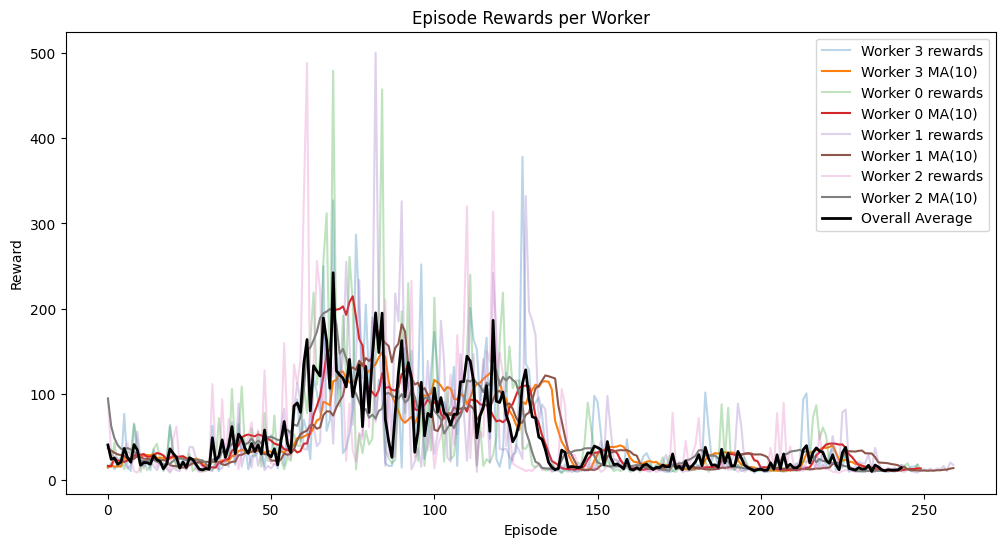

In [6]:
NUM_WORKERS = 4
MAX_EPISODES = 1000

global_episode = [0]
global_step = [0]
global_lock = threading.Lock()
optimizer_lock = threading.Lock()

# Shared dictionary to log rewards per worker
log_dict = {}

workers = []

for i in range(NUM_WORKERS):
    # Each worker gets its own Agent instance
    agent = Agent(
        global_actor,
        global_critic,
        global_actor_optimizer,
        global_critic_optimizer,
        state_dim,
        action_dim,
        optimizer_lock=optimizer_lock
    )
    
    # Pass log_dict to workers
    workers.append(Environment(
        ENV_NAME, 
        agent, 
        global_episode, 
        global_step, 
        global_lock, 
        MAX_EPISODES, 
        worker_id=i,
        log_dict=log_dict
    ))

# Start all workers
for worker in workers:
    worker.start()
    
# Wait for all workers to finish
for worker in workers:
    worker.join()

print("Training complete.")

# Plot the rewards
Environment.plot_rewards(log_dict, smoothing_window=10)


In [9]:
class EvalAgent:
    def __init__(self, global_actor, state_dim, action_dim):
        self.actor = global_actor  # Use global actor directly
        self.state_dim = state_dim
        self.action_dim = action_dim

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():  # No gradient tracking
            logits = self.actor(state)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
        return action.item()


def evaluate(global_actor, env_name, episodes=5):
    eval_agent = EvalAgent(global_actor, state_dim, action_dim)
    rewards = []

    for _ in range(episodes):
        state, _ = gym.make(env_name).reset()
        done = False
        ep_reward = 0.0
        while not done:
            action = eval_agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            state = next_state
        rewards.append(ep_reward)

    avg_reward = sum(rewards) / episodes
    print(f"[Eval] Avg reward over {episodes} episodes: {avg_reward:.2f}")
    return avg_reward


In [10]:
# Create evaluation agent
eval_agent = EvalAgent(global_actor, state_dim, action_dim)

# Number of evaluation episodes
EVAL_EPISODES = 10
total_rewards = []

# Create environment in RGB array mode for recording GIF
eval_env = gym.make(ENV_NAME, render_mode="rgb_array")

for ep in range(EVAL_EPISODES):
    state, _ = eval_env.reset()
    done = False
    ep_reward = 0.0
    frames = []  # store frames for GIF

    while not done:
        # Render and store frame
        frame = eval_env.render()
        frames.append(frame)

        # Take action
        action = eval_agent.act(state)
        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated
        ep_reward += reward
        state = next_state

    total_rewards.append(ep_reward)
    print(f"[Eval] Episode {ep+1} reward: {ep_reward:.2f}")

    # Save GIF for this episode
    gif_id = int(time.time())  # unique ID
    filename = f"eval_{gif_id}.gif"
    imageio.mimsave(filename, frames, fps=30)
    print(f"Saved GIF for episode {ep+1}: {filename}")

avg_reward = sum(total_rewards) / EVAL_EPISODES
print(f"[Eval] Average reward over {EVAL_EPISODES} episodes: {avg_reward:.2f}")

eval_env.close()


[Eval] Episode 1 reward: 11.00
Saved GIF for episode 1: eval_1766644560.gif
[Eval] Episode 2 reward: 16.00
Saved GIF for episode 2: eval_1766644560.gif
[Eval] Episode 3 reward: 12.00
Saved GIF for episode 3: eval_1766644561.gif
[Eval] Episode 4 reward: 14.00
Saved GIF for episode 4: eval_1766644561.gif
[Eval] Episode 5 reward: 12.00
Saved GIF for episode 5: eval_1766644561.gif
[Eval] Episode 6 reward: 17.00
Saved GIF for episode 6: eval_1766644562.gif
[Eval] Episode 7 reward: 11.00
Saved GIF for episode 7: eval_1766644562.gif
[Eval] Episode 8 reward: 18.00
Saved GIF for episode 8: eval_1766644562.gif
[Eval] Episode 9 reward: 13.00
Saved GIF for episode 9: eval_1766644563.gif
[Eval] Episode 10 reward: 11.00
Saved GIF for episode 10: eval_1766644563.gif
[Eval] Average reward over 10 episodes: 13.50
